<a href="https://colab.research.google.com/github/wkotala/DNN-HW1/blob/main/DNN-homework-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Multitask Learning for Geometric Shape Classification and Counting**

# Setup

In [176]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-15 19:05:40--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-15 19:05:41--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.1s    

2025-11-15 19:05:41 (51.1 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [177]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from numpy.typing import NDArray
from PIL import Image

FloatNDArray = NDArray[np.float64]
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Exploratory Data Analysis

In [178]:
data_dir = Path('data')
labels_df = pd.read_csv(data_dir / 'labels.csv')
labels_df

,name,squares,circles,up,right,down,left
0,img_00000.png,0,0,4,0,6,0
1,img_00001.png,0,0,0,5,0,5
2,img_00002.png,0,0,8,0,2,0
3,img_00003.png,0,7,0,0,0,3
4,img_00004.png,0,0,3,0,0,7
...,...,...,...,...,...,...,...
9995,img_09995.png,3,0,7,0,0,0
9996,img_09996.png,8,0,2,0,0,0
9997,img_09997.png,8,0,0,0,0,2
9998,img_09998.png,6,0,0,4,0,0


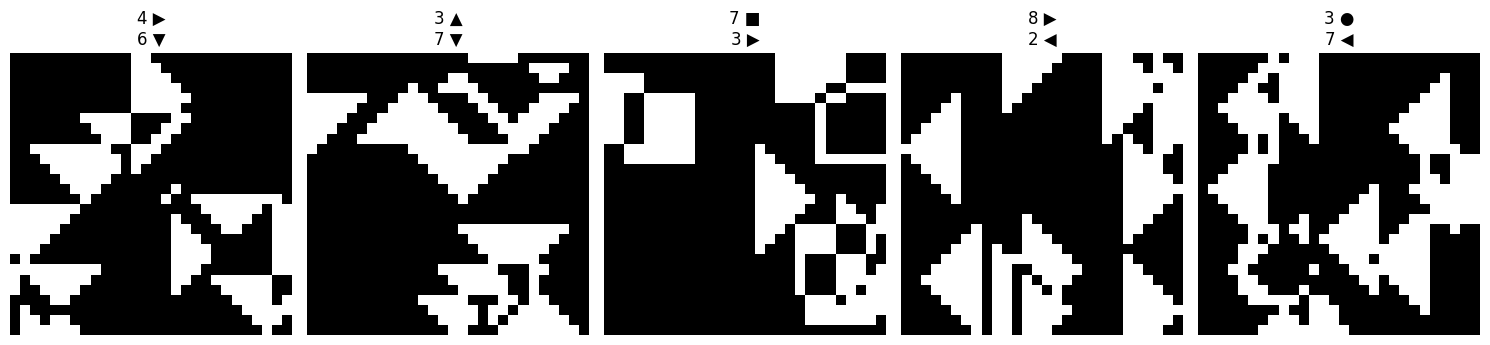

In [179]:
sample_df = labels_df[10:15]
shapes = {
    "squares": "\u25A0",
    "circles": "\u25CF",
    "up": "\u25B2",
    "right": "\u25B6",
    "down": "\u25BC",
    "left": "\u25C0",
}

fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 4))

for ax, row in zip(axes, sample_df.itertuples()):
    # Plot the image.
    img_path = data_dir / row.name
    img = Image.open(img_path)
    ax.imshow(img)

    # Display info about shapes in the image.
    title_parts = [
        f"{count} {shape_symbol}"
        for shape_name, shape_symbol in shapes.items()
        if (count := getattr(row, shape_name)) > 0
    ]
    ax.set_title("\n".join(title_parts))
    ax.axis('off')

plt.tight_layout()
plt.show()

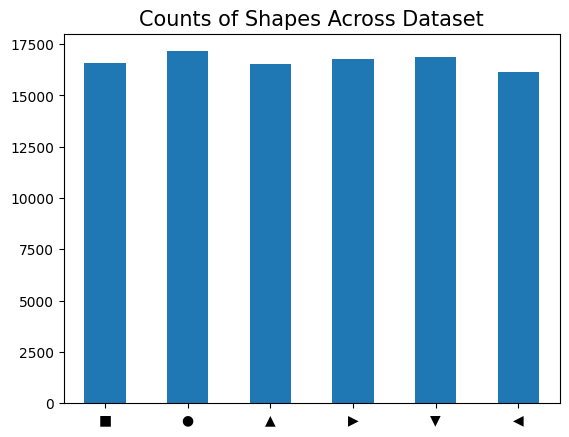

In [182]:
plt.title("Counts of Shapes Across Dataset", fontsize=14)
labels_df.drop('name', axis='columns').sum().rename(shapes).plot.bar(rot=0)
plt.show()

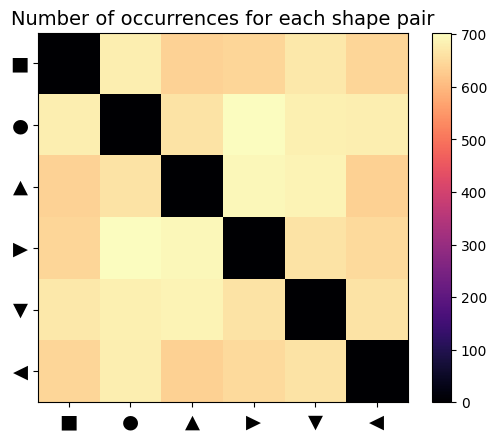

In [199]:
occurrence = (labels_df.drop('name', axis='columns') > 0).astype(int)
co_occurrence = occurrence.T @ occurrence
for i in range(len(co_occurrence)):
    co_occurrence.iat[i,i] = 0

# Draw a heatmap.
plt.title('Number of occurrences for each shape pair', fontsize=14)
plt.imshow(co_occurrence, cmap='magma')
plt.colorbar()

# Label the axes.
tick_positions = np.arange(len(co_occurrence.columns))
tick_labels = [shapes[name] for name in co_occurrence.columns]
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(tick_positions, tick_labels, fontsize=14, va='center')

plt.show()

# Data pipeline

# Model architecture